In [67]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/2020.deeplearning/master/init.py
from init import init; init(force_download=False)

In [68]:
import tensorflow as tf
from time import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle, bz2
from local.lib import mlutils
%matplotlib inline

## Check the following article on network architectures

- https://towardsdatascience.com/illustrated-10-cnn-architectures-95d78ace614d

In particular, 

- GlobalAveragePooling
- 1x1 convolutions
- Skip connections
- Networks modules:
    - **Inception**: multiple filter sizes on the same level (see [here](https://towardsdatascience.com/a-simple-guide-to-the-versions-of-the-inception-network-7fc52b863202))
    - **Resnet**: learns residuals, gradients back propagate larger to earlier layers (see [here](https://towardsdatascience.com/residual-blocks-building-blocks-of-resnet-fd90ca15d6ec))
    - **Xception**: depthwise separable convolutions (see [here](https://medium.com/@zurister/depth-wise-convolution-and-depth-wise-separable-convolution-37346565d4ec))
    

# Task: Use a Tensorflow hub model for image feature vector extraction

- browse this page, https://www.tensorflow.org/hub/common_signatures/images#image_feature_vector
- select a TF2.0 model that provides feature vector
- load and resize the mini-cifar2 dataset to the image size required by the selected model (see [`skimage.transform.resize`](https://scikit-image.org/docs/dev/api/skimage.transform.html?ref=driverlayer.com/web#skimage.transform.resize))
- apply the selected model layer to the resized mini-cifar2 dataset
- use any classical method from `scikit-learn` to create a classifier

In [69]:
!wget -nc https://s3.amazonaws.com/rlx/mini_cifar_2.h5

File ‘mini_cifar_2.h5’ already there; not retrieving.



(0.0, 1.0)

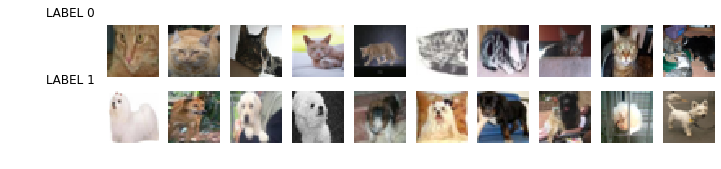

In [70]:
import h5py
with h5py.File('mini_cifar_2.h5','r') as h5f:
    x_cifar = h5f["x"][:][:1000]
    y_cifar = h5f["y"][:][:1000]
    
x_cifar = x_cifar[y_cifar!=2]    
y_cifar = y_cifar[y_cifar!=2]    
mlutils.show_labeled_image_mosaic(x_cifar, y_cifar)
np.min(x_cifar), np.max(x_cifar)

In [71]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_cifar, y_cifar, test_size=.2)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
print("\ndistribution of train classes")
print(pd.Series(y_train).value_counts())
print("\ndistribution of test classes")
print(pd.Series(y_test).value_counts())

(800, 32, 32, 3) (800,) (200, 32, 32, 3) (200,)

distribution of train classes
1    406
0    394
dtype: int64

distribution of test classes
0    109
1     91
dtype: int64


In [72]:
type(y_train)

numpy.ndarray

## Observe how we can apply a model to input data

- this example shows an untrained model
- you will have to do similarly with tfhub models

In [73]:
m = tf.keras.Sequential()
m.add(tf.keras.layers.InputLayer((32,32,3)))
m.add(tf.keras.layers.Flatten())
m.add(tf.keras.layers.Dense(20, activation="sigmoid"))


In [74]:
output = m(x_train.astype(np.float32)).numpy()
output.shape

(800, 20)

In [75]:
output

array([[0.42959306, 0.29780626, 0.7764532 , ..., 0.39441168, 0.5131183 ,
        0.35296747],
       [0.61642504, 0.269321  , 0.37405765, ..., 0.64106184, 0.49137992,
        0.606789  ],
       [0.41762146, 0.3894889 , 0.69675493, ..., 0.41105032, 0.50087595,
        0.347557  ],
       ...,
       [0.36967486, 0.42944083, 0.6887866 , ..., 0.58427495, 0.59694445,
        0.4843922 ],
       [0.46666062, 0.25185472, 0.71115035, ..., 0.4662612 , 0.65718603,
        0.337309  ],
       [0.41296956, 0.321532  , 0.72419757, ..., 0.49059623, 0.5019184 ,
        0.39245468]], dtype=float32)

## Your solution here

In [76]:
!pip install "tensorflow>=2.0.0
!pip install --upgrade tensorflow-hub

/bin/sh: 1: Syntax error: Unterminated quoted string
Requirement already up-to-date: tensorflow-hub in /home/user/.conda/envs/p37/lib/python3.7/site-packages (0.8.0)


In [77]:
import tensorflow_hub as hub
from skimage.transform import resize

x_newimg=[]
for i in range(len(x_train[:,0,0,0])):
    img=resize((x_train[i,:,:,:]),(96,96,3))
    x_newimg.append(img)

In [78]:
x_niarray=np.array(x_newimg)
x_niarray.shape


(800, 96, 96, 3)

the label is: 0


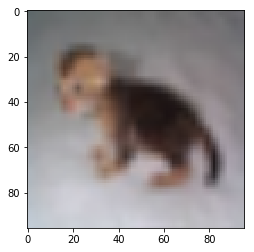

In [79]:
plt.imshow(x_niarray[0,:,:,:] , cmap='gray');
print('the label is:',y_train[0])

In [80]:
import tensorflow_hub as hub
from skimage.transform import resize

x_newtest_img=[]
for i in range(len(x_test[:,0,0,0])):
    img_test=resize((x_test[i,:,:,:]),(96,96,3))
    x_newtest_img.append(img_test)

In [81]:
x_ntest_iarray=np.array(x_newtest_img)
x_ntest_iarray.shape

(200, 96, 96, 3)

In [82]:

m = tf.keras.Sequential([hub.KerasLayer("https://tfhub.dev/google/imagenet/mobilenet_v2_050_96/feature_vector/4",
                   trainable=False),  # Can be True, see below.
    tf.keras.layers.Dense(20, activation='softmax')
])
m.build([None, 96, 96, 3])  # Batch input shape.

In [84]:
!rm -r -R ~/tmp/thub

rm: cannot remove '/home/user/tmp/thub': No such file or directory


In [85]:
m.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     multiple                  706224    
_________________________________________________________________
dense_5 (Dense)              multiple                  25620     
Total params: 731,844
Trainable params: 25,620
Non-trainable params: 706,224
_________________________________________________________________


In [86]:
m.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

In [87]:
hist = m.fit(x_niarray, y_train, batch_size=256, epochs=10, validation_split=0.3 )

Train on 560 samples, validate on 240 samples
Epoch 1/10
560/560 [==============================] - 5s 9ms/sample - loss: 38.2797 - accuracy: 0.0375 - val_loss: 37.6145 - val_accuracy: 0.0292
Epoch 2/10
560/560 [==============================] - 2s 3ms/sample - loss: 38.2317 - accuracy: 0.0411 - val_loss: 37.5327 - val_accuracy: 0.0292
Epoch 3/10
560/560 [==============================] - 2s 3ms/sample - loss: 38.1603 - accuracy: 0.0429 - val_loss: 37.4645 - val_accuracy: 0.0292
Epoch 4/10
560/560 [==============================] - 2s 3ms/sample - loss: 38.1077 - accuracy: 0.0429 - val_loss: 37.4103 - val_accuracy: 0.0292
Epoch 5/10
560/560 [==============================] - 2s 3ms/sample - loss: 38.0623 - accuracy: 0.0429 - val_loss: 37.3629 - val_accuracy: 0.0292
Epoch 6/10
560/560 [==============================] - 2s 3ms/sample - loss: 38.0274 - accuracy: 0.0429 - val_loss: 37.3316 - val_accuracy: 0.0292
Epoch 7/10
560/560 [==============================] - 2s 3ms/sample - loss: 38

In [88]:
m.evaluate(x_ntest_iarray, y_test)

200/200 [==============================] - 0s 2ms/sample - loss: 34.0757 - accuracy: 0.0450


[34.07565795898437, 0.045]

In [89]:
output = m(x_niarray.astype(np.float32)).numpy() 
output.shape

(800, 20)

In [90]:
output_test = m(x_ntest_iarray.astype(np.float32)).numpy()
output_test.shape

(200, 20)

In [91]:
from sklearn.ensemble import RandomForestClassifier

In [92]:
X=np.array(output)

rf=RandomForestClassifier(n_estimators=10, max_depth=10)
rf.fit(X,y_train)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

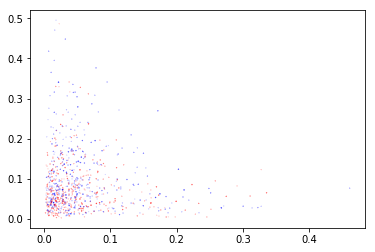

In [97]:
plt.scatter(X[y_train==0][:, 0], X[y_train==0][:, 1], X[y_train==0][:, 2],  color="red")#X[y_train==0][:, 3],
plt.scatter(X[y_train==1][:, 0], X[y_train==1][:, 1], X[y_train==1][:, 2],  color="blue")#X[y_train==1][:, 3],

In [98]:
x_ntest_iarray[:,0].shape

(200, 96, 3)

In [99]:
print (rf.score(output_test,y_test))


0.58


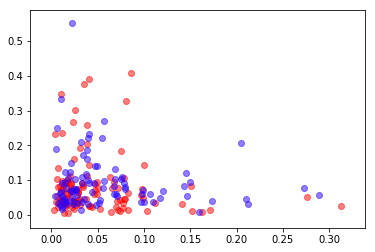

In [110]:

mlutils.plot_2Ddata(output_test, y_test)#, dots_alpha=.3


In [ ]:
mlutils.plot_2D_boundary(rf.predict, np.min(X, axis=0), np.max(X, axis=0),
                 line_width=20, line_alpha=.7, label=None)

In [180]:
test_preds = rf.predict(output_test).argmax(axis=0)
test_preds.shape
#mlutils.plot_confusion_matrix(y_test, test_preds, classes=np.r_[0,1,2], normalize=True)

()

In [174]:
X.shape


(800, 20)

In [101]:
from sklearn.svm import SVC

sv = SVC(gamma=1e-2)
sv.fit(X,y_train)
print (sv.score(X,y_train))

print ("number of support vectors", len(sv.support_vectors_))

0.5075
number of support vectors 789


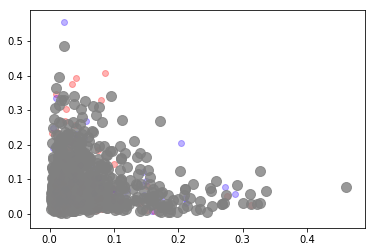

In [114]:
mlutils.plot_2Ddata(output_test, y_test, dots_alpha=.3)
plt.scatter(sv.support_vectors_[:,0], sv.support_vectors_[:,1], s=100, alpha=.8, color="gray")
  